### Data 

**Summary:** <br/>
This is a dataset from kaggle, The dataset records the users behavior when using two versions of a website and wheather they successfully converted (compeleted their intended task) or not.

**Dataset columns:** <br/>
`user_id` : unique-user identifier <br/>
`timestamp` : recorded time of usage <br/>
`group` : type of user group (Control or treatment) <br/>
`landing_page` : Which version of the website each user has been exposed to <br/>
`converted` : wheather the user successfully converted (compeleted his intended task) or not. 

### Goal of the Analysis

* Performing an A/B testing in order to copare the user behavior in using the two version of the site
* Evaluate the significance of our results

**The metricss** used for the test is the **Conversion Rate**
$$
Conversion Rate=\frac{Success Purchases}{Users Exposed}
$$

### Importing Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency,beta
import datetime as dt
from importlib import reload
plt=reload(plt)
pd.options.mode.chained_assignment = None

### Importing Data

In [16]:
df=pd.read_csv('ab_data.csv')
df.head(10)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


### Data validation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.isna().value_counts()

user_id  timestamp  group  landing_page  converted
False    False      False  False         False        294478
dtype: int64

In [5]:
df.duplicated().value_counts()

False    294478
dtype: int64

In [6]:
df[(df["group"]=="control") & df["landing_page"]=="new_page"]

,user_id,timestamp,group,landing_page,converted


In [7]:
df[(df["group"]=="treatment") & df["landing_page"]=="old_page"]

,user_id,timestamp,group,landing_page,converted


### Exploratory Data Analysis

* Pecentage of the control group vs. the treatment group

In [8]:
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

Text(0.5, 1.0, 'User groups')

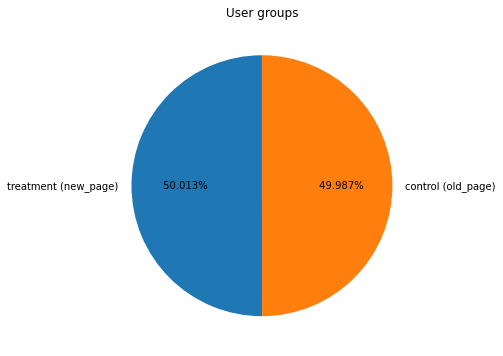

In [9]:
ax,fig=plt.subplots(figsize=(6,6))
ax=plt.pie(df['group'].value_counts(),labels=["treatment (new_page)",'control (old_page)'],autopct="% 1.3f%%",startangle=90)
plt.title("User groups")

* Conversion Rate amongst each group

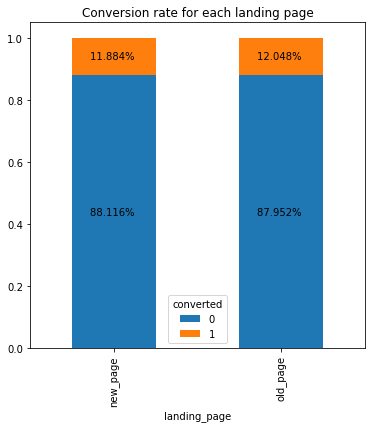

In [10]:
conversion=pd.crosstab(df["landing_page"],df["converted"],normalize="index").reset_index()
ax=conversion.plot(x="landing_page",kind='bar', stacked=True,
        title='Conversion rate for each landing page',figsize=(6,6))

for p in ax.patches:
    width, height = p.get_width(), p.get_height(),
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.3%} '.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')

### Testing

* Performin a Hypothesis testing taking the Null hypothesis as the two pages are the same and calculating the P value to evaluate wheather we accept or reject the null hypothesis

#### Using the Chi-squared method for testing (Frequentist)

In [11]:
# Constructing the contengency table for the test
contengency=pd.DataFrame(pd.crosstab(df["group"],df["converted"]).reset_index())
contengency.columns=[["group","not_converted","converted"]]
contengency


,group,not_converted,converted
0,control,129479,17723
1,treatment,129762,17514


In [12]:
control_not_converted=contengency.iloc[0,1]
control_converted=contengency.iloc[0,2]
treatment_not_converted=contengency.iloc[1,1]
treatment_converted=contengency.iloc[1,2]
con_table=np.array([[control_converted,control_not_converted],[treatment_converted,treatment_not_converted]])
con_table

array([[ 17723, 129479],
       [ 17514, 129762]], dtype=int64)

In [13]:
chi,p_value, _, _=chi2_contingency(con_table,correction=False)
print("Chi-Squared= ", chi)
print("P_value= ", p_value)

Chi-Squared=  1.5299754273296697
P_value=  0.21611613269757673


* As We can see, We have a large P value that we **cannot Reject the Null Hypothesis** So, The difference between the two pages **is not significant according to the Chi-Squared test**

**We Need to take another approach** that gives us more confidence in our result

#### We will perform  a **Bayesian Test** and to do so we need to build a **prior** in order to drive our **posterior results**

* For a prior we will consider the mean of conversion rate in the first week of the experiement for a premutated samples of the two pages 

In [40]:
df["timestamp"]=pd.to_datetime(df["timestamp"])
df["week"]=df["timestamp"].dt.isocalendar().week
prior=df[df["week"]==1]
prior


,user_id,timestamp,group,landing_page,converted,week
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1
17,888545,2017-01-08 06:37:26.332945,treatment,new_page,1,1
26,892356,2017-01-05 09:35:14.904865,treatment,new_page,1,1
29,736159,2017-01-06 01:50:21.318242,treatment,new_page,0,1
...,...,...,...,...,...,...
294465,925675,2017-01-07 20:38:26.346410,treatment,new_page,0,1
294467,857744,2017-01-05 08:00:56.024226,control,old_page,0,1
294468,643562,2017-01-02 19:20:05.460595,treatment,new_page,0,1
294472,822004,2017-01-04 03:36:46.071379,treatment,new_page,0,1


In [69]:
prior_mean=[]
for i in range(10000):
    prior_mean.append(
        prior.sample(1000)["converted"].mean()
    )
prior_mean[:10]

[0.107, 0.124, 0.118, 0.107, 0.133, 0.136, 0.125, 0.117, 0.119, 0.113]

* Using The Beta distribution to represent the samples means distribution 

In [70]:
alpha_0, beta_0, _, _,=beta.fit(prior_mean,floc=0,fscale=1)
alpha_0, beta_0

(119.32534573030118, 887.5243773494564)

* Adding the following weeks data to get the posterior control and the posterior treatment

In [71]:
experiement_data=df[df["week"]>1]
control=experiement_data[experiement_data["group"]=="control"]
treatment=experiement_data[experiement_data["group"]=="treatment"]
control_conversion=round(control["converted"].sum()*100/control["converted"].count(),4)
print("control conversion rate= ", control_conversion,"%")
treatment_conversion=round(treatment["converted"].sum()*100/treatment["converted"].count(),4)
print("treatment conversion rate= ", treatment_conversion,"%")
lift=round((treatment_conversion-control_conversion)/control_conversion,4)
print("The difference (lift)= ", lift,"%")

control conversion rate=  12.0825 %
treatment conversion rate=  11.9362 %
The difference (lift)=  -0.0121 %


* Now it's time to update our prior (by updating alpha_0 and beta_0) to get to the posterior distribution

By adding the successfull coversions to alpha_0 and the failed conversions to beta_0

In [72]:
exp_control_converted=control["converted"].sum()
exp_control_non_converted=control["converted"].count()-control["converted"].sum()
exp_treatment_converted=treatment["converted"].sum()
exp_treatment_non_converted=treatment["converted"].count()-treatment["converted"].sum()

# Updating the prior
posterior_control=beta(exp_control_converted+alpha_0,exp_control_non_converted+beta_0)
posterior_treatment=beta(exp_treatment_converted+alpha_0,exp_treatment_non_converted+beta_0)

* Now we sample from the posteriors and evaluate the probability of our calculated lift

In [76]:
posterior_control_sample=posterior_control.rvs(1000)
posterior_treatment_sample=posterior_treatment.rvs(1000)
probability=np.mean(posterior_treatment_sample>posterior_control_sample)*100
print("probability of the treatment conversion is more than the control conversion= ", probability,"%")

probability of the treatment conversion is more than the control conversion=  16.2 %


In [78]:
print("i.e we are", 100-probability, "% confident that the conversion rate in the control group is high than the ",
"conversionin the treatment group by", lift*-1,"% for the given sample")

i.e we are 83.8 % confident that the conversion rate in the control group is high than the  conversionin the treatment group by 0.0121 % for the given sample
